# Technical Challenge

## Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('./data/measurements.csv', encoding='latin')

In [3]:
df.sample()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
37,"4,9","7,4",26,"21,5",6,NaN,E10,0,0,0,NaN,NaN


In [4]:
df.shape

(388, 12)

In [5]:
df.isna().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

In [6]:
missing = [f'{i} {round(df[i].isnull().sum()/df[i].shape[0]*100, 2)}' for i in df]
missing

['distance 0.0',
 'consume 0.0',
 'speed 0.0',
 'temp_inside 3.09',
 'temp_outside 0.0',
 'specials 76.03',
 'gas_type 0.0',
 'AC 0.0',
 'rain 0.0',
 'sun 0.0',
 'refill liters 96.65',
 'refill gas 96.65']

We can see that columns `refill liters` and `refill gas` are almost entirely empty, for which they will be dropped to better fit the predictive model.

In [7]:
df.drop(columns=['refill liters', 'refill gas'], inplace=True)

In [8]:
df.specials.value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
AC snow                1
half rain half sun     1
AC sun                 1
AC Sun                 1
ac rain                1
Name: specials, dtype: int64

We can see that the column `specials` depicts already gathered data from other columns `AC`, `sun` and `rain`,and is primarily empty, for which it will be dropped to better fit the predictive model

In [9]:
df.drop(columns='specials', inplace=True)

In [10]:
df.gas_type.value_counts()

SP98    228
E10     160
Name: gas_type, dtype: int64

There are only 2 types of combustible in this dataset, Ethanol (E10) and unleaded 98 petrol (SP98).

## Visualization

In [11]:
#Some configuration for matplotlib and seaborn to look pretty
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config Inlinebackend.figure_format= 'retina'
sns.set_context("poster")
sns.set(rc={"figure.figsize": (18.,9.)})
sns.set_style("whitegrid")
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
df.distance = df.distance.apply(lambda x : x.replace(",", ".")).astype(float)
df.consume = df.consume.apply(lambda x : x.replace(",", ".")).astype(float)
df.temp_inside = df.temp_inside.apply(lambda x : x.replace(",", ".") if type(x)!=float else x).astype(float)

In [13]:
df.columns

Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside',
       'gas_type', 'AC', 'rain', 'sun'],
      dtype='object')

We need to change the cathegorical values of `gas_type` to numeric.

In [14]:
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['gas_type']]).toarray())
# merge with main df on key values
df = df.join(enc_df)
df.rename(columns={0: 'E10', 1: 'SP98'}, inplace=True)

<AxesSubplot:title={'center':'Correlation Heatmap'}>

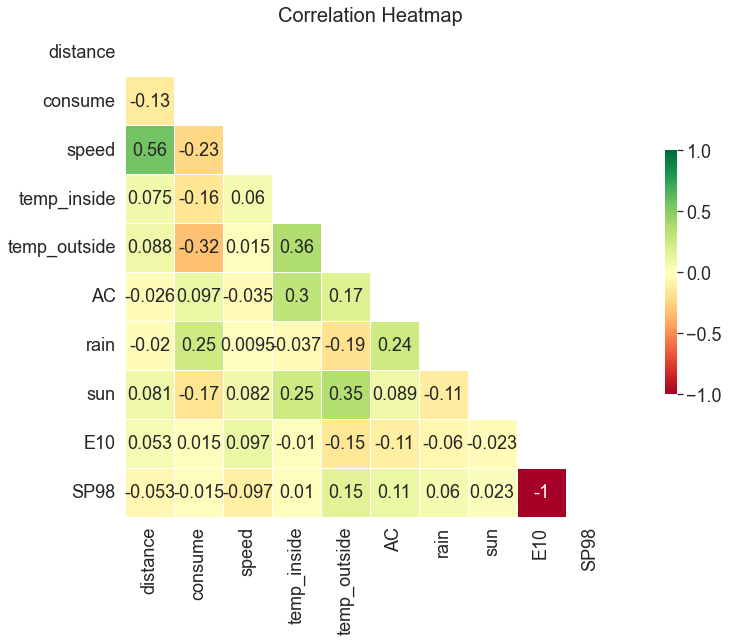

In [15]:
#Finding correlations within the df

#Set the variables
corrmat = df.corr()       
mask = np.triu(np.ones_like(corrmat, dtype=bool)) 
top_corr_features = corrmat.index
plt.title("Correlation Heatmap")

#Plot the heatmap
sns.heatmap(corrmat,  
            mask = mask,
            cmap='RdYlGn',
            square=True, 
            linewidth=0.5, 
            annot = True,
            vmax=1,
            vmin=-1,
            cbar_kws={"shrink": .5})

We can see that the corrrelation between consume and the gastype is not so obvious so we have to analyze the 

## Conclusion

In [16]:
df.drop(columns=['E10','SP98'], inplace=True)

In [17]:
df.sample()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
224,12.9,5.1,34,22.5,8,SP98,0,1,0


In [18]:
df['price'] = np.where(df.gas_type=='E10', 1.38, 1.46)

In [19]:
df = df.assign(trip_price=df.distance*df.consume*df.price/100)

In [21]:
df.groupby('gas_type').mean()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,price,trip_price
gas_type,,,,,,,,,,
E10,21.096250,4.931250,43.506250,21.917197,10.11875,0.043750,0.100000,0.075000,1.38,1.392327
SP98,18.639912,4.899123,40.820175,21.938356,12.22807,0.100877,0.140351,0.087719,1.46,1.290083


The SP98 continues to be a better option as the price per trip is lower than E10. This can be furthered explored through a deep graphical analysis